In [1]:
import os
print(os.getcwd())

data_folder = "\Input_dataset\\"
get_t = os.getcwd()
print(get_t +  data_folder)

C:\Users\mashv\.jupyter\Python notebooks\support-tickets-classification
C:\Users\mashv\.jupyter\Python notebooks\support-tickets-classification\Input_dataset\


In [2]:
from __future__ import print_function
import pandas as pd
import os
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve


def download_file(file_url, folder_path, data_folder, file_name):
#     file_path = os.path.join(folder_path, data_folder, file_name)
    file_path = os.getcwd()+ data_folder+ file_name
    if not os.path.exists(file_path):
        print('Downloading file from ' + file_url + '...')
        urlretrieve(file_url, file_path)
        print('Done downloading file: '+file_path)
        input_file= pd.read_csv(url)
    else:
        print('File: ' + file_path + ' already exists.')
        input_file= pd.read_csv(os.getcwd()+data_folder + file_name)
    return input_file


def download_dataset():
    print('Downloading Endava support tickets dataset...')
    folder_path =   os.getcwd() #os.path.join(         os.path.dirname(             os.path.abspath(__file__)        ),        'datasets'    )
    url = "https://privdatastorage.blob.core.windows.net/github/support-tickets-classification/datasets/all_tickets.csv"
    
    file_name = 'all_tickets.csv'
    input_data = download_file(url, folder_path, data_folder, file_name)
    return input_data


if __name__ == "__main__":
    input_data= download_dataset()

File: C:\Users\mashv\.jupyter\Python notebooks\support-tickets-classification\Input_dataset\all_tickets.csv already exists.


In [3]:
input_data.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [4]:
input_data.groupby('ticket_type').size()

ticket_type
0    13928
1    34621
dtype: int64

Shape of dataset before removing classes with less then 1 rows: (48549, 9)
Number of classes before removing classes with less then 1 rows: 2
Shape of dataset after removing classes with less then 1 rows: (48549, 9)
Number of classes after removing classes with less then 1 rows: 2
Training NB classifier
Evaluating model
Confusion matrix without GridSearch:
[[2473  249]
 [ 127 6861]]
Mean without GridSearch: 0.9612770339855818
Confusion matrix with GridSearch:
[[2643   79]
 [ 171 6817]]
Mean with GridSearch: 0.9742533470648815


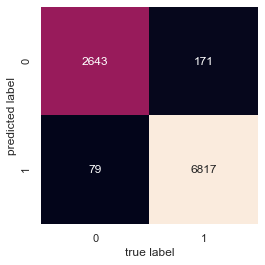

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2722
           1       0.99      0.98      0.98      6988

    accuracy                           0.97      9710
   macro avg       0.96      0.97      0.97      9710
weighted avg       0.97      0.97      0.97      9710



In [5]:
import sys
import nltk
import numpy as np
import pandas as pd
import pickle
# from helpers import *
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
import os
from matplotlib import pyplot as plt
sys.path.append(".")
sys.path.append("..")
# Use the Azure Machine Learning data preparation package
# from azureml.dataprep import package


class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])


column_to_predict = "ticket_type"
# column_to_predict = "business_service" 
# column_to_predict = "category" 
# Supported datasets:
# ticket_type
# business_service
# category
# impact
# urgency
# sub_category1
# sub_category2

classifier = "NB"  # Supported algorithms # "SVM" # "NB"
# classifier = "SVM"  # Supported algorithms # "SVM" # "NB"
use_grid_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = True  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = False  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 1  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1

if __name__ == '__main__':

    # TODO Add download dataset
     
    # loading dataset from dprep in Workbench    
    # dfTickets = package.run('AllTickets.dprep', dataflow_idx=0) 

    # loading dataset from csv
    file_name = 'all_tickets.csv'
    data_folder = "\Input_dataset\\"
    
    dfTickets = pd.read_csv((os.getcwd() + data_folder + file_name) , dtype=str)  

    text_columns = "body"  # "title" - text columns used for TF-IDF
    
    # Removing rows related to classes represented by low amount of data
    print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: "+str(dfTickets.shape))
    print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: "+str(len(np.unique(dfTickets[column_to_predict]))))
    bytag = dfTickets.groupby(column_to_predict).aggregate(np.count_nonzero)
    tags = bytag[bytag.body > min_data_per_class].index
    dfTickets = dfTickets[dfTickets[column_to_predict].isin(tags)]
    print(
        "Shape of dataset after removing classes with less then "
        + str(min_data_per_class) + " rows: "
        + str(dfTickets.shape)
    )
    print(
        "Number of classes after removing classes with less then "
        + str(min_data_per_class) + " rows: "
        + str(len(np.unique(dfTickets[column_to_predict])))
    )

    labelData = dfTickets[column_to_predict]
    data = dfTickets[text_columns]

    # Split dataset into training and testing data
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labelData, test_size=0.2
    )  # split data to train/test sets with 80:20 ratio

    # Extracting features from text
    # Count vectorizer
    if remove_stop_words:
        count_vect = CountVectorizer(stop_words=stop_words_lang)
        count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
    elif use_stemming:
        count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
    else:
        count_vect = CountVectorizer()

    # Fitting the training data into a data processing pipeline and eventually into the model itself
    if classifier == "NB":
        print("Training NB classifier")
        # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
        # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
        # We will be using the 'text_clf' going forward.

        text_clf = Pipeline([
            ('vect', count_vect),
            ('tfidf', TfidfTransformer()),
            ('clf', MultinomialNB(fit_prior=fit_prior))
        ])
        text_clf = text_clf.fit(train_data, train_labels)

    elif classifier == "SVM":
        print("Training SVM classifier")
        # Training Support Vector Machines - SVM
        text_clf = Pipeline([(
            'vect', count_vect),
            ('tfidf', TfidfTransformer()),
            ('clf', SGDClassifier(
                loss='hinge', penalty='l2', alpha=1e-3,
                max_iter=5, random_state=42
            )
        )])
        text_clf = text_clf.fit(train_data, train_labels)

    if use_grid_search:
        # Grid Search
        # Here, we are creating a list of parameters for which we would like to do performance tuning.
        # All the parameters name start with the classifier name (remember the arbitrary name we gave).
        # E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.
        
        # NB parameters
        parameters = {
            'vect__ngram_range': [(1, 1), (1, 2)],
            'tfidf__use_idf': (True, False),
            'clf__alpha': (1e-2, 1e-3)
        }

#         SVM parameters
#         parameters = {
#            'vect__max_df': (0.5, 0.75, 1.0),
#            'vect__max_features': (None, 5000, 10000, 50000),
#            'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
#            'tfidf__use_idf': (True, False),
#            'tfidf__norm': ('l1', 'l2'),
#            'clf__alpha': (0.00001, 0.000001),
#            'clf__penalty': ('l2', 'elasticnet'),
#            'clf__max_iter': (10 , 15) #, 50, 80),
#         }

        # Next, we create an instance of the grid search by passing the classifier, parameters
        # and n_jobs=-1 which tells to use multiple cores from user machine.
        gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
        gs_clf = gs_clf.fit(train_data, train_labels)

        # To see the best mean score and the params, run the following code
        gs_clf.best_score_
        gs_clf.best_params_

    print("Evaluating model")
    # Score and evaluate model on test data using model without hyperparameter tuning
    predicted = text_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix without GridSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean without GridSearch: " + str(prediction_acc))

    # Score and evaluate model on test data using model WITH hyperparameter tuning
    if use_grid_search:
        predicted = gs_clf.predict(test_data)
        prediction_acc = np.mean(predicted == test_labels)
        print("Confusion matrix with GridSearch:")
        print(metrics.confusion_matrix(test_labels, predicted))
        print("Mean with GridSearch: " + str(prediction_acc))

    # Ploting confusion matrix with 'seaborn' module
    # Use below line only with Jupyter Notebook
    # %matplotlib inline
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import matplotlib
    mat = confusion_matrix(test_labels, predicted)
    plt.figure(figsize=(4, 4))
    sns.set()
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=np.unique(test_labels),
                yticklabels=np.unique(test_labels))
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    # Save confusion matrix to outputs in Workbench
    # plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
    plt.show()

    # Printing classification report
    # Use below line only with Jupyter Notebook
    from sklearn.metrics import classification_report
    print(classification_report(test_labels, predicted,
                                target_names=np.unique(test_labels)))

    # Save trained models to /output folder
    # Use with Workbench
    if use_grid_search:
        pickle.dump(
            gs_clf,
            open(os.path.join('.', 'outputs', column_to_predict+".model"),'wb')
        )
    else:
        pickle.dump(
            text_clf,
            open(os.path.join(
                '.', 'outputs', column_to_predict+".model"),
                'wb'
            )
        )

In [8]:
train_labels.head()

30697    1
14393    1
4338     1
18848    1
31344    1
Name: ticket_type, dtype: object

In [12]:
text_clf.fit

<bound method Pipeline.fit of Pipeline(memory=None,
         steps=[('vect',
                 StemmedCountVectorizer(analyzer='word', binary=False,
                                        decode_error='strict',
                                        dtype=<class 'numpy.int64'>,
                                        encoding='utf-8', input='content',
                                        lowercase=True, max_df=1.0,
                                        max_features=None, min_df=1,
                                        ngram_range=(1, 1), preprocessor=None,
                                        stop_words='english',
                                        strip_accents=None,
                                        token_pattern='(?u)\\b\\w\\w+\\b',
                                        tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),